## 0. Introduction & Objectives

In the highly competitive digital music market, personalized recommendations are vital for user
engagement and retention. A critical obstacle, however, is the "cold start" problem, where
traditional methods fail to recommend content to new users due to a lack of historical data. This
project proposes to address this by developing a robust Content-Based Recommendation
System that leverages intrinsic musical features and the k-Nearest Neighbors (kNN) model to
provide accurate, item-to-item suggestions.

#### Objectives
- Investigate how quantitative audio features define musical similarity.
- Utilize learned techniques, including PCA and Clustering for analysis and visualization.
- Provide actionable insights into which specific features most strongly influence musical
genre or mood grouping.
- Develop a stable feature-based kNN model to recommend similar tracks.

## 1. Install Dependencies

In [1]:
#pip install -r requirements.txt

## 2. Data Loading & Cleaning

In [2]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# load dataset
df = pd.read_csv("data/data.csv")

In [3]:
# Check missing values & duplicates
missing = df.isnull().sum().sum()
duplicates = df.duplicated().sum()

print(f"Number of missing rows: {missing}\nNumber of duplicate rows: {duplicates}")

Number of missing rows: 0
Number of duplicate rows: 0


In [4]:
# Drop duplicate artist-song pairs
df = df.drop_duplicates(subset=['artists', 'name'], keep='first')

## 3. Exploratoy Data Analysis (EDA) & Preprocessing

### 3-1. Dataset Overview

In [5]:
# print df info to view available columns and dtypes
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 157685 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           157685 non-null  float64
 1   year              157685 non-null  int64  
 2   acousticness      157685 non-null  float64
 3   artists           157685 non-null  object 
 4   danceability      157685 non-null  float64
 5   duration_ms       157685 non-null  int64  
 6   energy            157685 non-null  float64
 7   explicit          157685 non-null  int64  
 8   id                157685 non-null  object 
 9   instrumentalness  157685 non-null  float64
 10  key               157685 non-null  int64  
 11  liveness          157685 non-null  float64
 12  loudness          157685 non-null  float64
 13  mode              157685 non-null  int64  
 14  name              157685 non-null  object 
 15  popularity        157685 non-null  int64  
 16  release_date      157685 

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,157685.000000,157685.000000,157685.000000,157685.000000,1.576850e+05,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000,157685.000000
mean,0.527579,1976.613039,0.504277,0.536762,2.305950e+05,0.480694,0.087263,0.167909,5.200774,0.206755,-11.502779,0.705977,31.445845,0.100937,116.799153
std,0.263225,25.955146,0.376070,0.176398,1.264735e+05,0.267640,0.282220,0.313854,3.516040,0.175506,5.699130,0.455604,21.957673,0.167698,30.754080
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.316000,1956.000000,0.103000,0.414000,1.694000e+05,0.254000,0.000000,0.000000,2.000000,0.099000,-14.669000,0.000000,11.000000,0.035000,93.240000
50%,0.538000,1977.000000,0.522000,0.547000,2.069470e+05,0.468000,0.000000,0.000224,5.000000,0.136000,-10.618000,1.000000,34.000000,0.045300,114.726000
75%,0.746000,1999.000000,0.894000,0.668000,2.621730e+05,0.701000,0.000000,0.106000,8.000000,0.263000,-7.210000,1.000000,48.000000,0.077000,135.519000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


### 3-2. Define audio features
To use the k-Nearest Neighbors (kNN) algorithm, we selected features that **quantitatively** characterize a track's "musical identity". `valence`, `energy`, `danceability`, `acousticness` defines mood and atmosphere. `tempo`, `loudness`, `instrumentalness` defines rhythm and intensity. `year`, `popularity` provides contextual information. 

During the Exploratory Data Analysis (EDA), we identified a subset of data (196 rows) containing zero values for `valence` and `tempo`. We determined these zero values as corrupted data or extraction errors. Since they constitute a negligible portion of the dataset (< 0.12%), we removed these rows to prevent them from distorting the distance calculations in the kNN model.

We retained rows with zero values for `acousticness`, `instrumentalness`, and `popularity` because, unlike tempo or valence where zero indicates data corruption, these zeros carry valid semantic meaning. A value of 0 in acousticness or instrumentalness correctly identifies tracks that are purely electronic or vocal-heavy, while a 0 in popularity represents new or niche releases essential for solving the "cold start" problem.

In [6]:
# audio features
audio_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
]

af = df[audio_features]

print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,157685.0,0.504277,0.376070,0.0,0.103,0.522000,0.894,0.996
danceability,157685.0,0.536762,0.176398,0.0,0.414,0.547000,0.668,0.988
energy,157685.0,0.480694,0.267640,0.0,0.254,0.468000,0.701,1.000
instrumentalness,157685.0,0.167909,0.313854,0.0,0.000,0.000224,0.106,1.000
liveness,157685.0,0.206755,0.175506,0.0,0.099,0.136000,0.263,1.000
loudness,157685.0,-11.502779,5.699130,-60.0,-14.669,-10.618000,-7.210,3.855
speechiness,157685.0,0.100937,0.167698,0.0,0.035,0.045300,0.077,0.970
tempo,157685.0,116.799153,30.754080,0.0,93.240,114.726000,135.519,243.507
valence,157685.0,0.527579,0.263225,0.0,0.316,0.538000,0.746,1.000


### 3-3. Zero Value Handling
- Remove valence=0, tempo=0 (corrupted)
- Keep acousticness=0, instrumentalness=0 (valid)

In [7]:
# remove corrupted rows
# 'tempo', 'danceability', and 'energy' columns also have 0s, but are a subset of rows with valence == 0
af = af[af['valence']>0]
print("Audio Features Statistics:")
af.describe().T

Audio Features Statistics:


,count,mean,std,min,25%,50%,75%,max
acousticness,157504.0,0.504143,0.376024,0.00000,0.103,0.522000,0.89400,0.996
danceability,157504.0,0.537235,0.175755,0.05510,0.415,0.547000,0.66800,0.988
energy,157504.0,0.481074,0.267435,0.00002,0.254,0.468000,0.70100,1.000
instrumentalness,157504.0,0.167499,0.313492,0.00000,0.000,0.000222,0.10500,1.000
liveness,157504.0,0.206682,0.175390,0.00967,0.099,0.136000,0.26300,1.000
loudness,157504.0,-11.487207,5.666405,-54.83700,-14.656,-10.611000,-7.20800,3.744
speechiness,157504.0,0.100993,0.167728,0.02220,0.035,0.045300,0.07700,0.970
tempo,157504.0,116.899549,30.574648,30.94600,93.311,114.767000,135.55125,243.507
valence,157504.0,0.528185,0.262767,0.00001,0.317,0.538000,0.74600,1.000


### 3-4. Feature Distribution Analysis

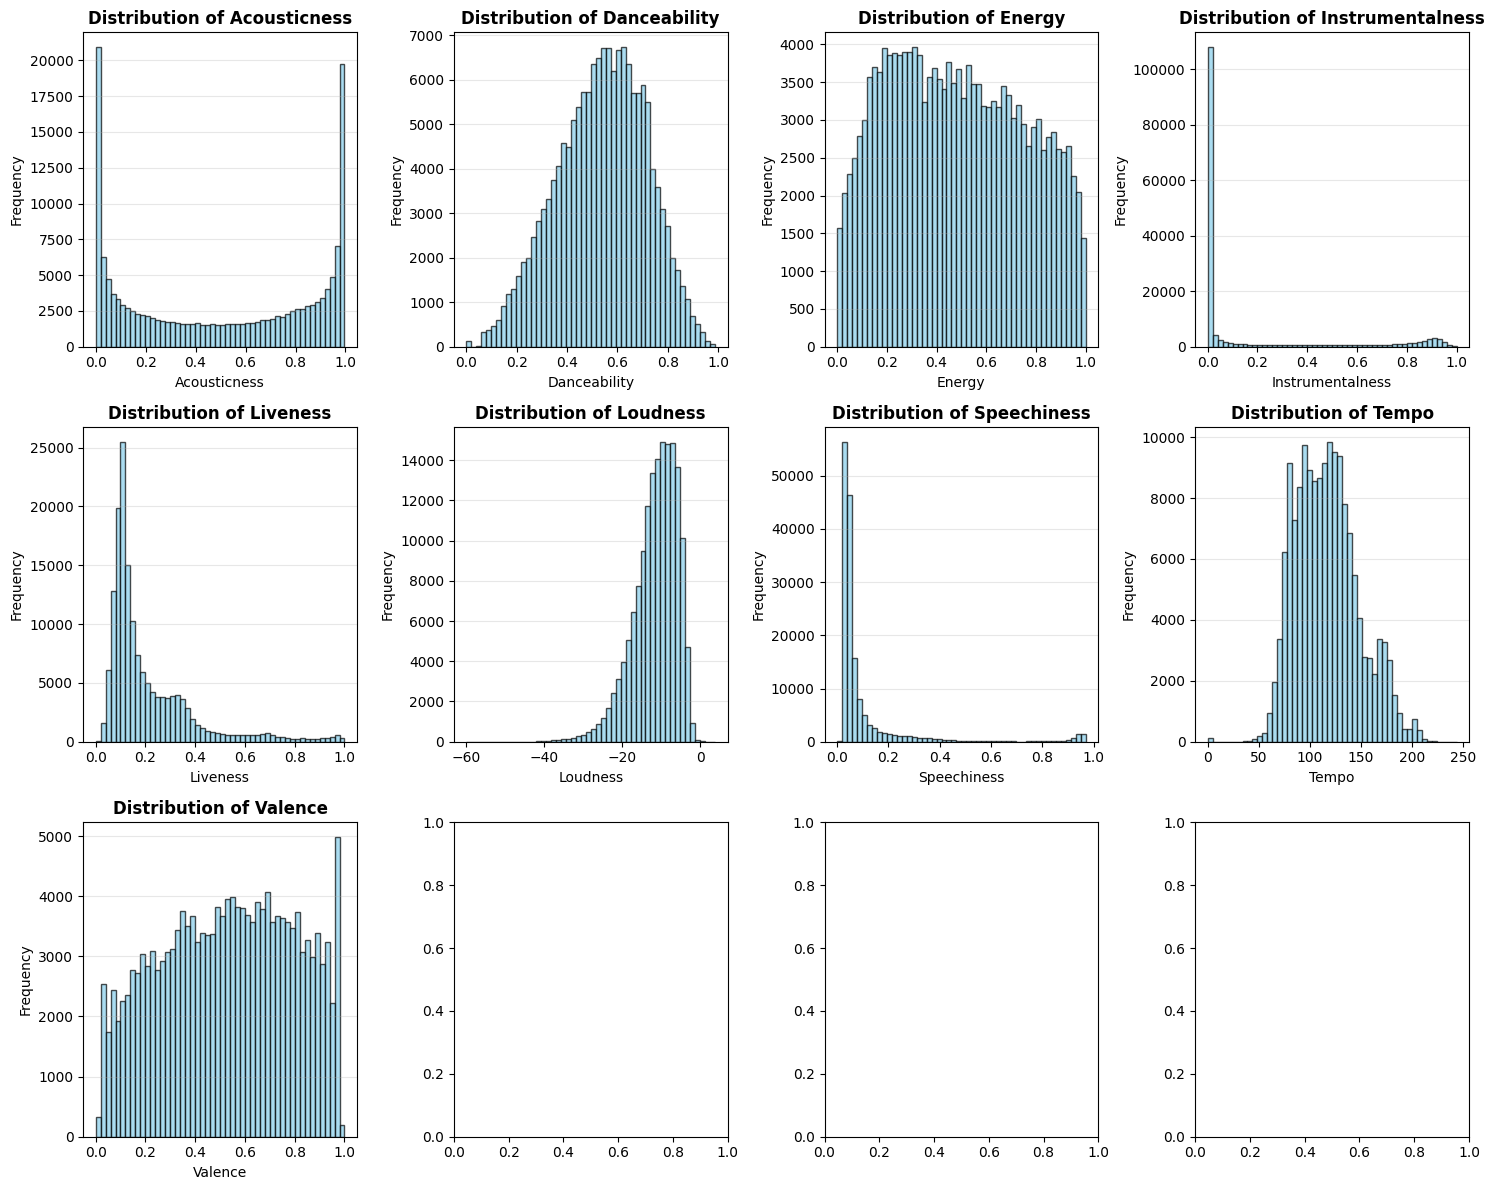

In [8]:
# Plot distributions
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(df[feature].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {feature.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3-5. Correlation Heatmap 

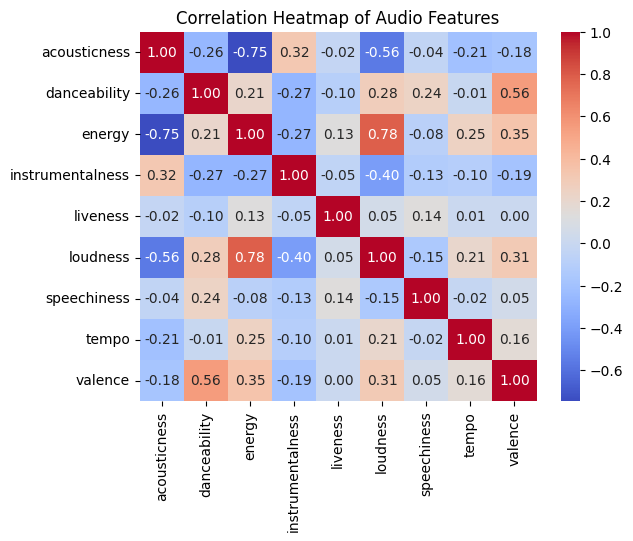

In [9]:
plt.figure()
correlation_matrix = af[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

### 3-6. Feature Standardization 

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
af_scaled_np = scaler.fit_transform(af)
af_scaled = pd.DataFrame(af_scaled_np, columns=af.columns, index=af.index)
af_scaled

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,1.270819,-1.469289,-1.009870,2.266416,2.613147,-1.519274,-0.383916,-1.175669,-1.784038
1,0.605966,1.603173,-0.523769,-0.534304,-0.266164,-0.168325,1.872131,-1.830396,1.654758
2,1.214971,-1.190491,-1.178135,2.378063,-0.602558,-0.593463,-0.400013,-0.214575,-1.860152
3,1.230928,-1.492048,-0.643424,-0.534216,0.993891,0.383173,-0.391070,-0.549167,-1.382160
4,1.204334,-0.678414,-1.077176,-0.534299,0.127247,0.245519,-0.375569,-0.498275,-1.047262
...,...,...,...,...,...,...,...,...,...
170648,-1.115737,1.415412,1.222456,-0.533382,-0.709749,1.373928,-0.076869,-0.388249,0.303748
170649,-0.792884,1.022819,1.016798,-0.534304,-0.602558,0.964849,-0.241422,0.688038,0.783261
170650,-1.072122,0.550570,1.409418,-0.534277,0.292594,1.634411,-0.119796,-0.824593,0.414112
170651,-1.314182,0.761091,0.530697,-0.534280,2.487712,0.763486,1.234189,-1.368607,-1.267991


In [11]:
temp = df.loc[af.index]

meta_cols = ['name', 'artists', 'id', 'release_date', 'popularity', 'year']
df_meta = temp[meta_cols]

df_clean = pd.concat([df_meta, af_scaled], axis=1)

## 4. Clustering Analysis

### 4-1. Determine number of clusters using K-means

In [12]:
# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11) 

print("Testing different numbers of clusters:")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(af_scaled_np)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (on a sample for speed)
    sample_size = min(10000, len(af_scaled_np))
    sample_idx = np.random.choice(len(af_scaled_np), sample_size, replace=False)
    silhouette = silhouette_score(af_scaled_np[sample_idx], kmeans.labels_[sample_idx])
    silhouette_scores.append(silhouette)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}")

Testing different numbers of clusters:
k=2: Inertia=1079923.33, Silhouette=0.238
k=3: Inertia=936425.32, Silhouette=0.261
k=4: Inertia=830867.22, Silhouette=0.215
k=5: Inertia=750278.55, Silhouette=0.187
k=6: Inertia=681933.17, Silhouette=0.196
k=7: Inertia=632331.13, Silhouette=0.185
k=8: Inertia=595668.24, Silhouette=0.184
k=9: Inertia=564474.52, Silhouette=0.182
k=10: Inertia=542237.93, Silhouette=0.181


### 4-2. Elbow curve and Silhouette scores visualization

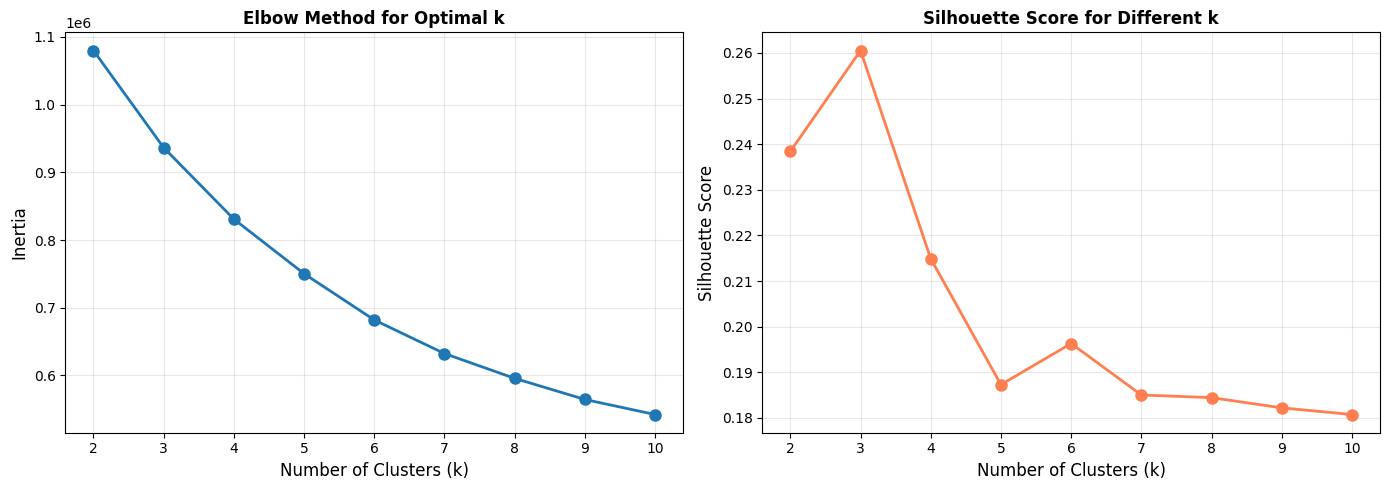

Clustering analysis completed!


In [13]:
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontweight='bold')
ax1.grid(alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Clustering analysis completed!")

### 4-3. PCA visualization [k 모름]

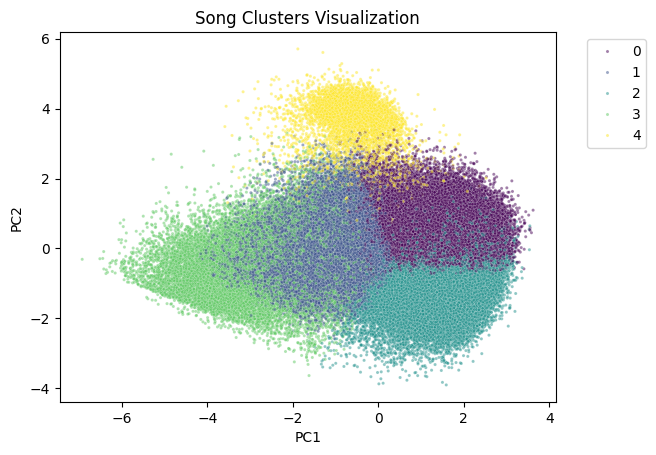

array([3, 0, 3, ..., 0, 2, 0], shape=(157504,), dtype=int32)

In [31]:
# 1. Clustering
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(af_scaled)




# 2. PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(af_scaled)

# 3. Visualization prep
pca_df = pd.DataFrame(pca_coords, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['name'] = df_clean['name'].values

# 4. KNN model Prep
df_clean['cluster'] = clusters

# 5. Plot figure
plt.figure()
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2',
    hue='Cluster', palette='viridis',
    alpha=0.5, s=5
)
plt.title('Song Clusters Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
clusters

## 5. kNN Model

### 5-1. Implementation of KNN model

In [27]:

# Function for Cluster-based kNN 
def get_recommendations(artist, title, k=5):
    
    # 노래 찾기 (df_clean에서!)
    song = df_clean[(df_clean['artists'].str.contains(artist, case=False, na=False)) & 
                    (df_clean['name'].str.contains(title, case=False, na=False))]
    
    if len(song) == 0:
        return "Song not found!"
    
    # ✅ df_clean의 실제 index 사용
    idx = song.index[0]
    cluster = df_clean.loc[idx, 'cluster']
    
    # ✅ 같은 cluster의 row들
    cluster_mask = df_clean['cluster'] == cluster
    cluster_df = df_clean[cluster_mask]
    
    # ✅ numpy array에서 같은 index 위치 찾기
    # df_clean의 index를 af_scaled_np의 위치로 변환
    cluster_positions = np.where(cluster_mask)[0]
    cluster_features = af_scaled_np[cluster_positions]
    
    # ✅ input song의 위치 찾기
    input_position = df_clean.index.get_loc(idx)
    
    # kNN
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn.fit(cluster_features)
    
    # ✅ input song의 features (cluster 내에서의 위치)
    input_cluster_position = np.where(cluster_positions == input_position)[0][0]
    distances, indices = knn.kneighbors(cluster_features[input_cluster_position].reshape(1, -1))
    
    # 결과 (자기 자신 제외)
    result_positions = cluster_positions[indices[0][1:]]
    result_indices = df_clean.index[result_positions]
    
    return df_clean.loc[result_indices, ['artists', 'name', 'year']]

### 5-2. Visualize recommendations using PCA

In [28]:
#visualization function: 
def visualize_recommendations(artist, title, k=5):
    """
    Visualize input song and its k recommendations in 2D PCA space
    
    Parameters:
    - artist: Artist name
    - title: Song title
    - k: Number of recommendations to show
    
    """
    
    # Get recommendations
    recs = get_recommendations(artist, title, k)
    
    # Check if song was found
    if isinstance(recs, str):
        print(recs)
        return
    
    # Find input song in df_clean
    input_song = df_clean[(df_clean['artists'].str.contains(artist, case=False, na=False)) & 
                          (df_clean['name'].str.contains(title, case=False, na=False))]
    
    if len(input_song) == 0:
        print("Song not found!")
        return
    
    input_idx = input_song.index[0]
    
    # Get positions in the numpy array (X_pca uses same order as df_clean)
    # df_clean's index might not be sequential, so we need to map it
    input_position = df_clean.index.get_loc(input_idx)
    rec_positions = [df_clean.index.get_loc(idx) for idx in recs.index]
    
    # Create plot
    plt.figure(figsize=(12, 8))
    X_pca= pca_coords

    # Plot all songs as background (light gray, small)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                alpha=0.1, s=1, c='lightgray', label='All songs')
    
    # Plot recommended songs (blue circles)
    plt.scatter(X_pca[rec_positions, 0], X_pca[rec_positions, 1], 
                c='dodgerblue', s=150, marker='o', 
                label=f'Top {k} Recommendations', 
                edgecolor='black', linewidth=2, alpha=0.8, zorder=3)
    
    # Plot input song (red star) - largest, on top
    plt.scatter(X_pca[input_position, 0], X_pca[input_position, 1], 
                c='red', s=500, marker='*', 
                label='Input Song', 
                edgecolor='black', linewidth=2.5, zorder=4)
    
    # Draw lines connecting input to recommendations (optional but nice)
    for rec_pos in rec_positions:
        plt.plot([X_pca[input_position, 0], X_pca[rec_pos, 0]],
                 [X_pca[input_position, 1], X_pca[rec_pos, 1]],
                 'k--', alpha=0.3, linewidth=1, zorder=1)
    
    # Labels and styling
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    plt.title(f'kNN Recommendations for "{title}" by {artist}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right', fontsize=11, framealpha=0.9)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    # Save figure
    safe_filename = f"{artist.replace(' ', '_')}_{title.replace(' ', '_')}_recommendations.png"
    plt.savefig(safe_filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print cluster info
    input_cluster = df_clean.loc[input_idx, 'cluster']
    rec_clusters = recs.index.map(lambda idx: df_clean.loc[idx, 'cluster'])

    print(f"\n📊 Cluster Information:")
    print(f"Input song cluster: {input_cluster}")
    print(f"All recommendations are in cluster: {input_cluster}")
    print(f"✅ kNN successfully found similar songs within the same cluster!")

### 5-3. Interactive Input System: 

🎵 Music Recommendation System



Enter artist name (or 'quit' to exit):  BTS
Enter song title:  IDOL
How many recommendations? (default=5):  5



Recommendations for 'IDOL' by BTS
                        artists  \
140335   ['BTS', 'Nicki Minaj']   
16676   ['Panic! At The Disco']   
162991            ['Heaven 17']   
37247           ['Flame', 'NF']   
153331           ['María José']   

                                                     name  year  
140335                                               IDOL  2018  
16676   Lying Is the Most Fun a Girl Can Have Without ...  2005  
162991                                         Temptation  1982  
37247                               Start Over (feat. NF)  2013  
153331           No Soy una Señora (Non Sono una Signora)  2009  



Visualize in PCA space? (y/n):  y


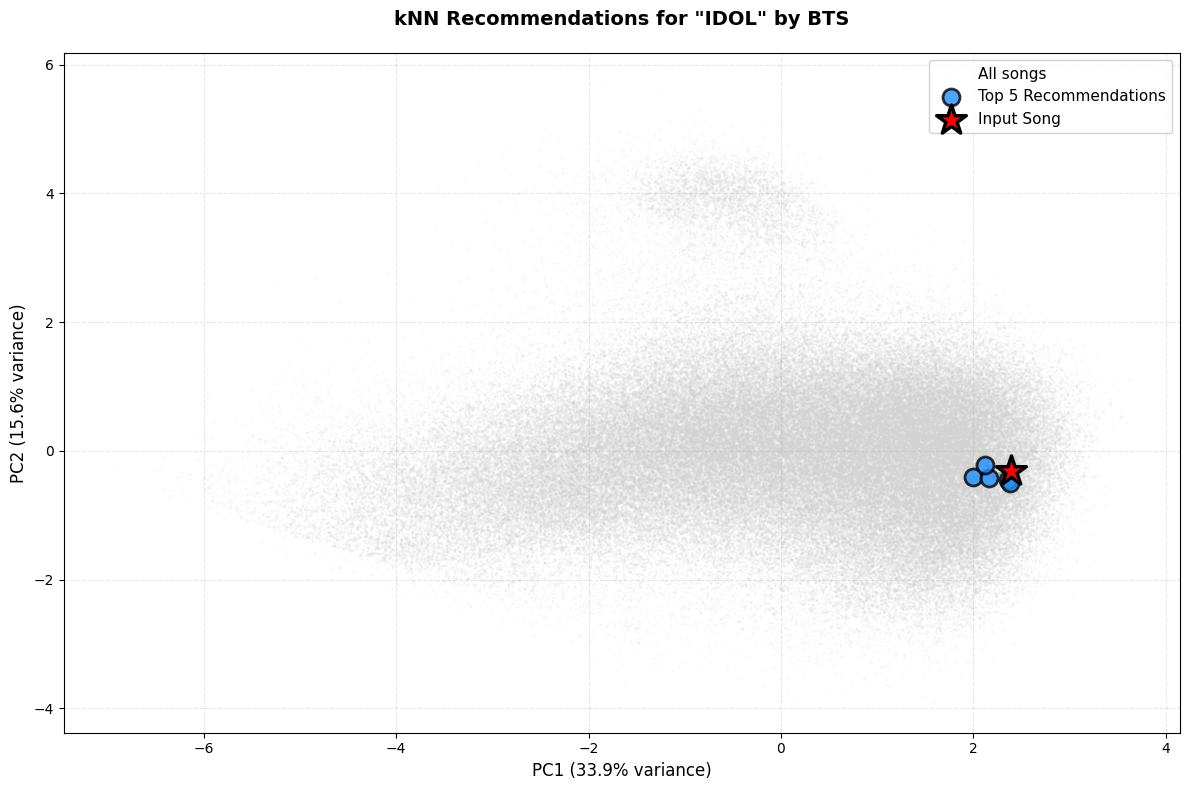


📊 Cluster Information:
Input song cluster: 2
All recommendations are in cluster: 2
✅ kNN successfully found similar songs within the same cluster!



Enter artist name (or 'quit' to exit):  quit


Thanks for using the recommendation system!


In [17]:
### Interactive Recommendation System

def interactive_recommendations():
    """
    Interactive recommendation system - user inputs artist and song
    """
    print("🎵 Music Recommendation System")
    print("=" * 60)
    
    while True:
        artist = input("\nEnter artist name (or 'quit' to exit): ")
        
        if artist.lower() == 'quit':
            print("Thanks for using the recommendation system!")
            break
            
        title = input("Enter song title: ")
        k = input("How many recommendations? (default=5): ")
        k = int(k) if k else 5
        
        print("\n" + "=" * 60)
        print(f"Recommendations for '{title}' by {artist}")
        print("=" * 60)
        
        recs = get_recommendations(artist, title, k)
        
        if isinstance(recs, str):
            print(recs)
        else:
            print(recs[['artists', 'name', 'year']])
            
        # Ask if user wants visualization
        viz = input("\nVisualize in PCA space? (y/n): ")
        if viz.lower() == 'y':
            visualize_recommendations(artist, title, k)

# Run it
interactive_recommendations()

## 6. Model Evaluation


MODEL EVALUATION - Cosine Distance Analysis

Artist               Song                           kNN Distance    Random Distance
--------------------------------------------------------------------------------
Ed Sheeran           Shape of You                   0.0126          0.5899
Queen                Bohemian Rhapsody              0.0275          1.2973
The Beatles          Let It Be                      0.0207          1.0128
Taylor Swift         Shake It Off                   0.0108          1.2043
Drake                Hotline Bling                  0.0153          0.9105
Daft Punk            Get Lucky                      0.0046          0.8903
Adele                Hello                          0.0137          0.8996
Metallica            Enter Sandman                  0.0124          0.4639
BTS                  Dynamite                       0.0091          0.6808
Billie Eilish        bad guy                        0.0398          0.8938
---------------------------------------

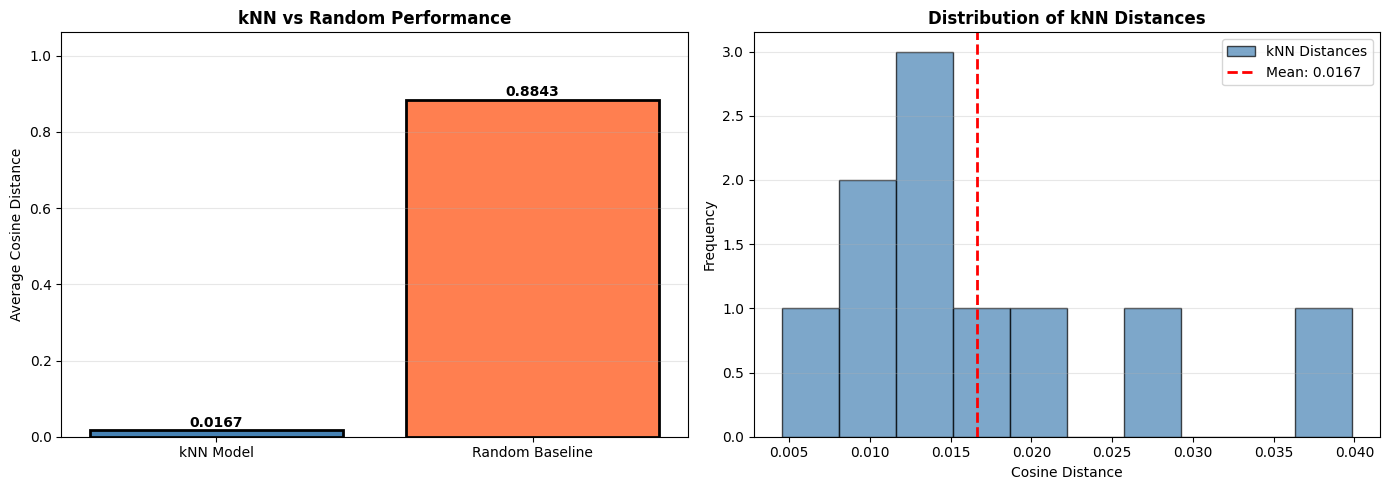

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances

def evaluate_model_performance(test_songs):
    """
    Evaluate recommendation system performance by calculating average cosine distance
    between input songs and their recommendations.
    
    Lower distance indicates higher similarity (better performance).
    Compares kNN performance against random baseline.
    
    Parameters:
    - test_songs: List of (artist, title) tuples
    
    Returns:
    - Dictionary with performance metrics
    """
    results = []
    random_baselines = []
    not_found = []
    
    print("\n" + "=" * 80)
    print("MODEL EVALUATION - Cosine Distance Analysis")
    print("=" * 80 + "\n")
    print(f"{'Artist':<20} {'Song':<30} {'kNN Distance':<15} {'Random Distance':<15}")
    print("-" * 80)
    
    for artist, title in test_songs:
        # Get recommendations
        recs = get_recommendations(artist, title, k=5)
        
        # Handle not found
        if isinstance(recs, str): 
            print(f"{artist:<20} {title:<30} NOT FOUND")
            not_found.append((artist, title))
            continue
            
        # Find input song features
        input_song_row = df_clean[
            (df_clean['artists'].str.contains(artist, case=False, na=False)) & 
            (df_clean['name'].str.contains(title, case=False, na=False))
        ].iloc[0]
        
        # Get input vector (standardized features)
        input_idx = df_clean.index.get_loc(input_song_row.name)
        input_vector = af_scaled_np[input_idx].reshape(1, -1)
        
        # Get recommendation vectors
        rec_vectors = []
        for idx in recs.index:
            rec_pos = df_clean.index.get_loc(idx)
            rec_vectors.append(af_scaled_np[rec_pos])
        rec_vectors = np.array(rec_vectors)
        
        # Calculate cosine distance for kNN recommendations
        distances = cosine_distances(input_vector, rec_vectors)
        avg_dist = np.mean(distances)
        results.append(avg_dist)
        
        # Baseline: Calculate distance to 5 random songs
        random_indices = np.random.choice(len(af_scaled_np), 5, replace=False)
        random_vectors = af_scaled_np[random_indices]
        random_dist = np.mean(cosine_distances(input_vector, random_vectors))
        random_baselines.append(random_dist)
        
        print(f"{artist:<20} {title:<30} {avg_dist:.4f}          {random_dist:.4f}")
    
    # Summary statistics
    print("-" * 80)
    
    if len(results) == 0:
        print("\n⚠️  No songs found in dataset - cannot evaluate")
        return None
    
    overall_avg = np.mean(results)
    baseline_avg = np.mean(random_baselines)
    improvement = ((baseline_avg - overall_avg) / baseline_avg * 100)
    
    print(f"\n📊 PERFORMANCE SUMMARY:")
    print(f"  • kNN Average Distance:       {overall_avg:.4f}")
    print(f"  • Random Baseline Distance:   {baseline_avg:.4f}")
    print(f"  • Improvement over Random:    {improvement:.1f}%")
    print(f"  • Best Case (min distance):   {min(results):.4f}")
    print(f"  • Worst Case (max distance):  {max(results):.4f}")
    print(f"  • Standard Deviation:         {np.std(results):.4f}")
    
    print(f"\n📈 TEST COVERAGE:")
    print(f"  • Songs Successfully Found:   {len(results)}/{len(test_songs)} ({len(results)/len(test_songs)*100:.1f}%)")
    if not_found:
        print(f"  • Songs Not Found: {len(not_found)}")
        for artist, title in not_found:
            print(f"      - {title} by {artist}")
    
    print(f"\n💡 INTERPRETATION GUIDE:")
    print(f"  • Distance < 0.1  → Excellent similarity")
    print(f"  • Distance < 0.3  → Good similarity")
    print(f"  • Distance < 0.5  → Moderate similarity")
    print(f"  • Distance > 0.5  → Poor similarity")
    
    if overall_avg < baseline_avg:
        print(f"\n✅ SUCCESS: kNN outperforms random by {improvement:.1f}%")
        print(f"   The cluster-based kNN model successfully identifies similar songs.")
    else:
        print(f"\n⚠️  WARNING: Model needs improvement")
    
    print("=" * 80 + "\n")
    
    return {
        'knn_avg': overall_avg,
        'random_avg': baseline_avg,
        'improvement': improvement,
        'best': min(results),
        'worst': max(results),
        'std': np.std(results),
        'coverage': len(results) / len(test_songs),
        'results': results,
        'baselines': random_baselines
    }

# ========================================
# Test with diverse genres
# ========================================

test_set = [
    ("Ed Sheeran", "Shape of You"),        # Pop
    ("Queen", "Bohemian Rhapsody"),        # Rock
    ("The Beatles", "Let It Be"),          # Classic Rock
    ("Taylor Swift", "Shake It Off"),      # Pop
    ("Drake", "Hotline Bling"),            # Hip-Hop/R&B
    ("Daft Punk", "Get Lucky"),            # Electronic
    ("Adele", "Hello"),                    # Soul/Ballad
    ("Metallica", "Enter Sandman"),        # Metal
    ("BTS", "Dynamite"),                   # K-Pop (might not exist)
    ("Billie Eilish", "bad guy"),          # Alternative
]

metrics = evaluate_model_performance(test_set)

# Optional: Visualize results
if metrics:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar chart comparing kNN vs Random
    comparison = pd.DataFrame({
        'Method': ['kNN Model', 'Random Baseline'],
        'Avg Distance': [metrics['knn_avg'], metrics['random_avg']]
    })
    ax1.bar(comparison['Method'], comparison['Avg Distance'], 
            color=['steelblue', 'coral'], edgecolor='black', linewidth=2)
    ax1.set_ylabel('Average Cosine Distance')
    ax1.set_title('kNN vs Random Performance', fontweight='bold')
    ax1.set_ylim(0, max(metrics['knn_avg'], metrics['random_avg']) * 1.2)
    ax1.grid(alpha=0.3, axis='y')
    
    # Add values on bars
    for i, (method, dist) in enumerate(zip(comparison['Method'], comparison['Avg Distance'])):
        ax1.text(i, dist + 0.01, f'{dist:.4f}', ha='center', fontweight='bold')
    
    # Distribution of distances
    ax2.hist(metrics['results'], bins=10, color='steelblue', 
             edgecolor='black', alpha=0.7, label='kNN Distances')
    ax2.axvline(metrics['knn_avg'], color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {metrics["knn_avg"]:.4f}')
    ax2.set_xlabel('Cosine Distance')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of kNN Distances', fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 7. Feature Importance Analysis

cluster
0    50082
1    43494
2    35878
3    22410
4     5640
Name: count, dtype: int64
Feature means by cluster (standardized values):
          valence  acousticness  danceability    energy  instrumentalness  \
cluster                                                                     
0        0.820328     -0.454810      0.862773  0.497645         -0.334109   
1       -0.449724      0.783197     -0.377550 -0.804994         -0.418829   
2       -0.217517     -0.965032     -0.389414  1.024330         -0.238986   
3       -0.617646      1.020210     -0.769546 -0.975814          2.067314   
4        0.021654      0.084030      0.785228 -0.849922         -0.497296   

         liveness  loudness  speechiness     tempo  
cluster                                             
0       -0.295876  0.478149    -0.094810 -0.025013  
1       -0.043793 -0.412327    -0.259599 -0.241106  
2        0.479105  0.770498    -0.112877  0.592604  
3       -0.166931 -1.195709    -0.261454 -0.357878  
4    

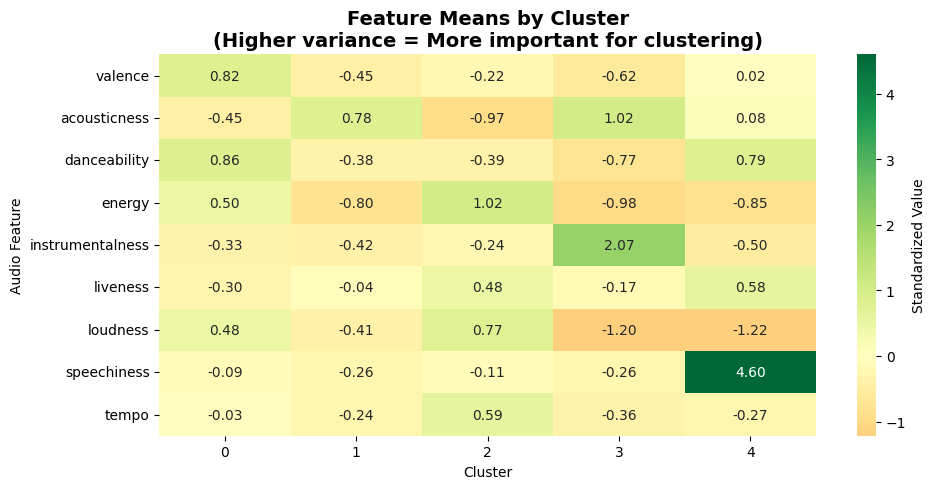

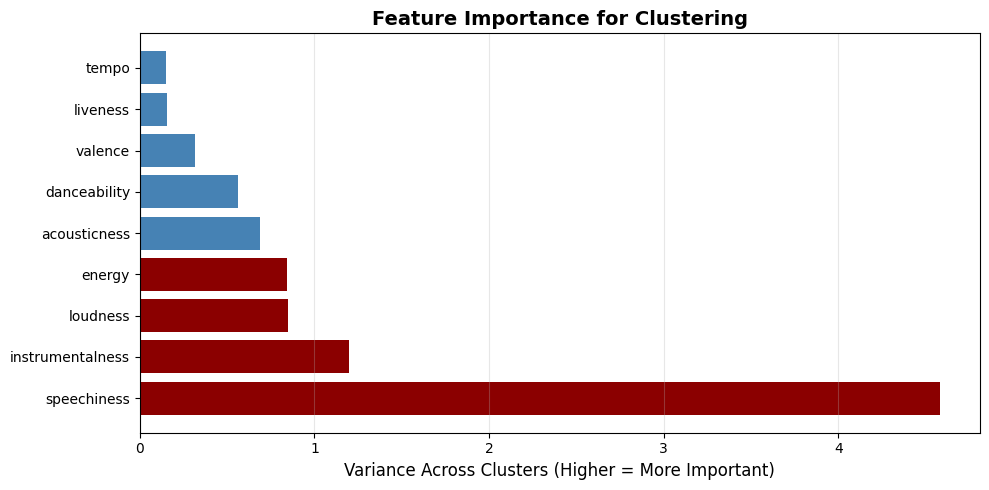


💡 INTERPRETATION:
High importance features (top 3):
  • speechiness: Strongly distinguishes between musical styles
  • instrumentalness: Strongly distinguishes between musical styles
  • loudness: Strongly distinguishes between musical styles

Low importance features (bottom 3):
  • valence: Similar across all clusters
  • liveness: Similar across all clusters
  • tempo: Similar across all clusters


In [32]:
## Feature Importance Analysis

"""
Determine which audio features most strongly distinguish between clusters.
"""

feature_names = ['valence', 'acousticness', 'danceability', 'energy', 
                 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']



print(df_clean['cluster'].value_counts())

# Calculate mean feature values for each cluster
cluster_means = df_clean.groupby('cluster')[feature_names].mean()

print("Feature means by cluster (standardized values):")
print(cluster_means)

# Calculate variance across clusters (higher = more important for clustering)
feature_variance = cluster_means.var(axis=0).sort_values(ascending=False)

print("\nFeature Importance (variance across clusters):")
for i, (feature, var) in enumerate(feature_variance.items(), 1):
    print(f"{i}. {feature:<20} {var:.4f}")

# Visualize with heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Standardized Value'})
plt.title('Feature Means by Cluster\n(Higher variance = More important for clustering)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Audio Feature')
plt.tight_layout()
plt.show()

# Bar chart of variance
plt.figure(figsize=(10, 5))
colors = ['darkred' if v > feature_variance.median() else 'steelblue' 
          for v in feature_variance.values]
plt.barh(feature_variance.index, feature_variance.values, color=colors)
plt.xlabel('Variance Across Clusters (Higher = More Important)', fontsize=12)
plt.title('Feature Importance for Clustering', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Interpretation
print("\n💡 INTERPRETATION:")
print(f"High importance features (top 3):")
for feature in feature_variance.head(3).index:
    print(f"  • {feature}: Strongly distinguishes between musical styles")
print(f"\nLow importance features (bottom 3):")
for feature in feature_variance.tail(3).index:
    print(f"  • {feature}: Similar across all clusters")

### Feature Importance Analysis

**Results:**
1. **Speechiness** (variance = 4.58): Most discriminative feature
   - Primarily driven by Cluster 4 with extremely high speech content, which most likely contains rap/ hiphop songs
   - Distinguishes vocal-heavy genres from instrumental music
   
2. **Instrumentalness** (variance = 1.20): Second most important
   - Separates classical/ambient (Cluster 3) from vocal-heavy genres
   - Instrumental vs vocal is a primary genre distinction
   
3. **Loudness** (variance = 0.85): Important for energy-based separation
   - Rock/EDM (loud) vs Classical (quiet)
   
4. **Energy** (variance = 0.84): Closely related to loudness
   - High-energy dance/rock vs low-energy acoustic/classical

**Key Insight:**
The high variance in speechiness reveals an important finding: speech content
is a critical distinguishing factor in music genres. Rap/hip-hop (Cluster 4)
is fundamentally characterized by high speech density, making it distinct from
other genres. This validates the importance of including speechiness in 
content-based music analysis, contrary to the common assumption that melodic
and rhythmic features alone define musical similarity.

## 8. Conclusion